In [417]:
import os
import glob
from datetime import datetime
from datetime import timezone
import polars as pl
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn import linear_model
import numpy as np
import math
from sklearn.metrics import r2_score

# start_date = datetime(2023, 11, 17, 0, 0, 0).replace(tzinfo=timezone.utc)
# end_date = datetime(2023, 11, 28, 15, 59, 59).replace(tzinfo=timezone.utc)
# system_ids = [18]

#start_date = datetime(2023, 12, 22, 15, 0, 0).replace(tzinfo=timezone.utc)
start_date = datetime(2024, 1, 12, 20, 0, 0).replace(tzinfo=timezone.utc)
end_date = datetime(2024, 1, 30, 23, 59, 59).replace(tzinfo=timezone.utc)
system_ids = [3,6,10,11,12,13,16,18,20]

filter = '1h'

DATA_DIRECTORY = os.environ.get("DATA_DIRECTORY")
PICARRO_DATA_DIRECTORy = os.environ.get("PICARRO_DATA_DIRECTORY")


In [418]:
def rmse(y_true, y_meas):
    MSE = np.square(np.subtract(y_true, y_meas)).mean()
    RMSE = math.sqrt(MSE)

    return RMSE

def calc_r2(y_true, y_meas):
    return r2_score(y_true, y_meas)

In [419]:
df_cal = pl.scan_parquet(os.path.join(DATA_DIRECTORY, "processed", "slope_intercept_acropolis.parquet")) \
    .with_columns((pl.col("creation_timestamp").dt.timestamp("ms") / 3.6e6).alias("timestamp")) #3.6e6 ms are in 1h

# Perform RANSAC only on slope and then select valid calibrations

In [420]:
def fit_ransac(x, y, date):
    #x = range(len(y))

    Y = np.array(y)
    X = np.array(x)
    T = np.array(date)

    # Robustly fit linear model with RANSAC algorithm
    ransac = linear_model.RANSACRegressor(residual_threshold=0.01)
    ransac.fit(X.reshape(-1, 1), Y)
    inlier_mask = ransac.inlier_mask_
    outlier_mask = np.logical_not(inlier_mask)
    line_X = np.arange(X.min(), X.max())[:, np.newaxis]
    line_y_ransac = ransac.predict(line_X)
    
    # plot
    lw = 2
    
    plt.scatter(
        X[inlier_mask], Y[inlier_mask], color="yellowgreen", marker=".", label="Inliers"
    )
    plt.scatter(
        X[outlier_mask], Y[outlier_mask], color="gold", marker=".", label="Outliers"
    )
    plt.plot(
        line_X,
        line_y_ransac,
        color="cornflowerblue",
        linewidth=lw,
        label="RANSAC regressor",
    )
    plt.legend()
    plt.xlabel("Unix Time (h)")
    plt.ylabel(f"slope for system: {id}")
    plt.show()
    #----
    
    return inlier_mask

In [421]:
df_cal.filter(pl.col("system_name") == f"tum-esm-midcost-raspi-12").filter(pl.col("creation_timestamp").is_between(start_date, end_date)).collect()

date,system_name,slope,intercept,creation_timestamp,timestamp
date,str,f64,f64,"datetime[μs, UTC]",f64
2024-01-13,"""tum-esm-midcos…",1.025663,6.393243,2024-01-13 09:44:53 UTC,473649.748056
2024-01-14,"""tum-esm-midcos…",1.028739,5.154645,2024-01-14 03:30:58.760 UTC,473667.516322
2024-01-15,"""tum-esm-midcos…",1.054955,-5.484378,2024-01-15 03:31:15.660 UTC,473691.521017
2024-01-16,"""tum-esm-midcos…",1.055092,-8.06096,2024-01-16 03:03:31.650 UTC,473715.058792


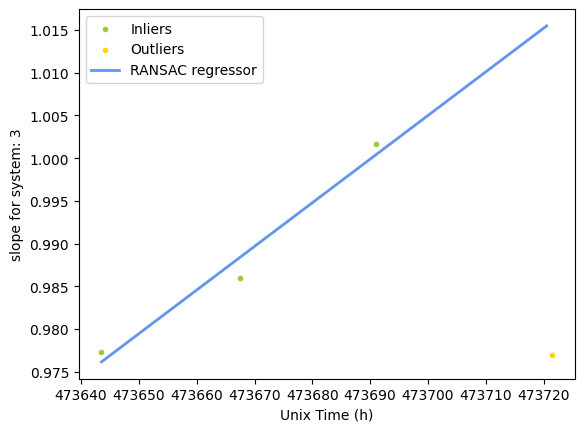

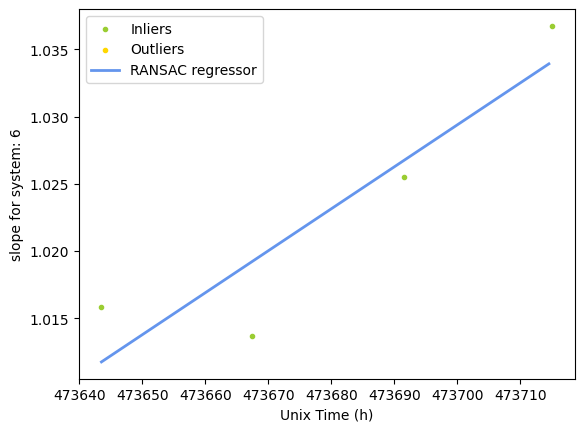

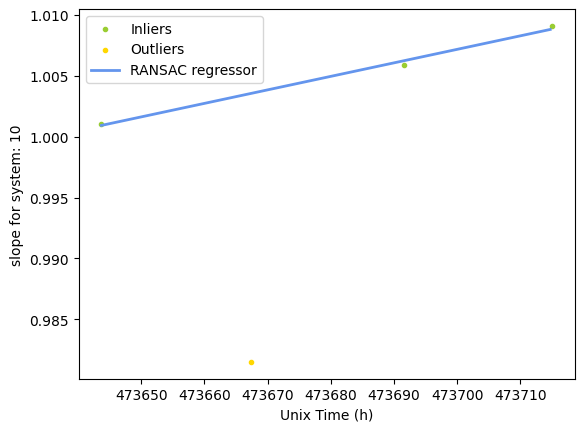

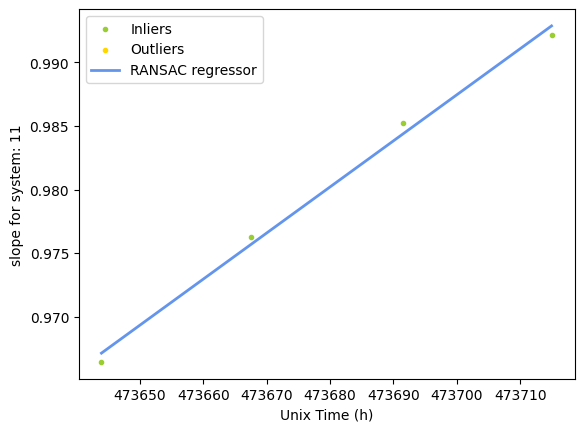

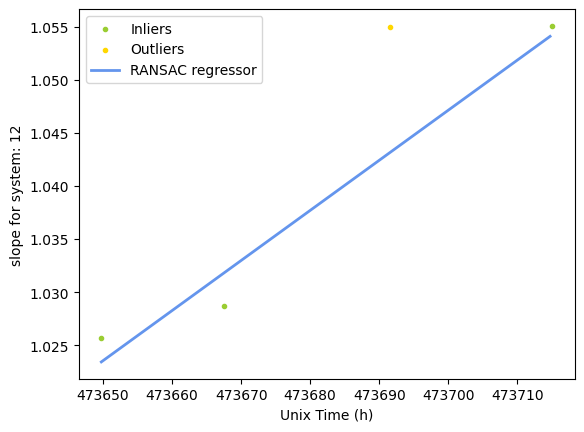

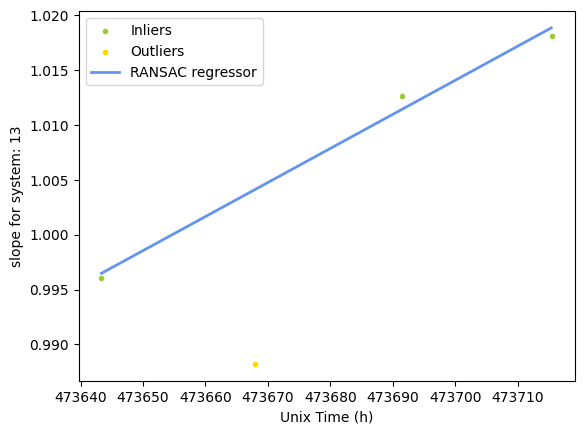

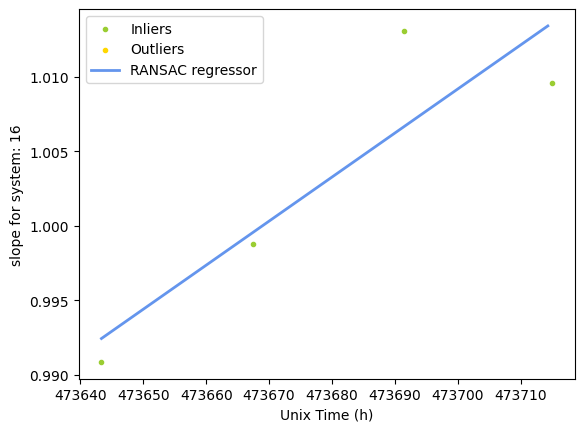

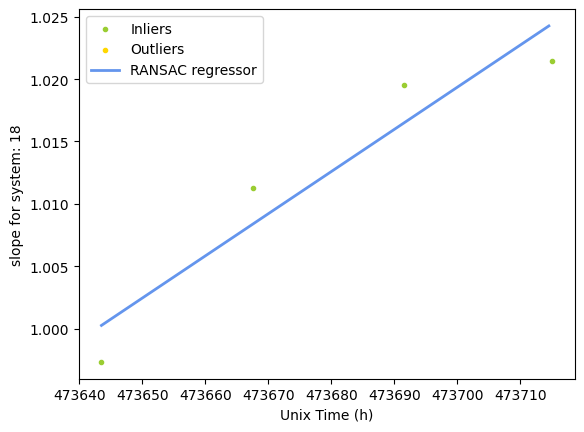

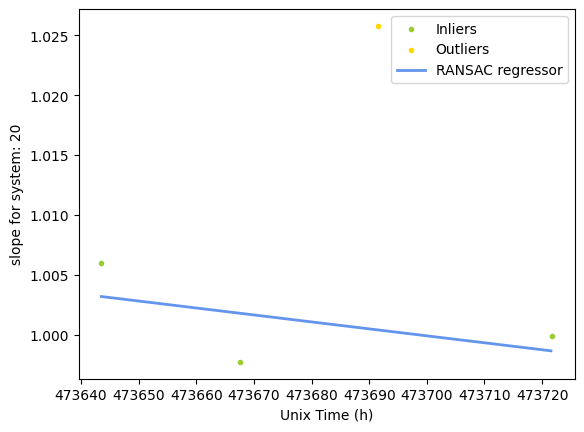

In [434]:
l_df_cor = []

for id in system_ids:
    try:
        df_sys = df_cal.filter(pl.col("system_name") == f"tum-esm-midcost-raspi-{id}").filter(pl.col("creation_timestamp").is_between(start_date, end_date))

        y = df_sys.select(pl.col("slope")).collect().to_series().to_list()
        x = df_sys.select(pl.col("timestamp")).collect().to_series().to_list()
        d = df_sys.select(pl.col("creation_timestamp")).collect().to_series().to_list()
        mask = fit_ransac(x,y,d)

        df_sys = df_sys.with_columns(mask = pl.Series(mask)).collect()
        
        l_df_cor.append(df_sys)
    except Exception as e:
        print(e)
        print(f"Could not find calibrations for system {id}")
    

df_cal_ransac = pl.concat(l_df_cor, how="diagonal")

In [423]:
df_cal_ransac = df_cal_ransac.with_columns((pl.col("slope") * pl.col("mask")).alias("ransac_slope")) \
    .with_columns((pl.col("intercept") * pl.col("mask")).alias("ransac_intercept")) \
    .filter(pl.col("mask") == True) \
    .sort("creation_timestamp") \
    .lazy()
    
df_cal_ransac.head(3).collect()

date,system_name,slope,intercept,creation_timestamp,timestamp,mask,ransac_slope,ransac_intercept
date,str,f64,f64,"datetime[μs, UTC]",f64,bool,f64,f64
2024-01-13,"""tum-esm-midcos…",0.990875,-23.246768,2024-01-13 03:20:22.460 UTC,473643.339572,true,0.990875,-23.246768
2024-01-13,"""tum-esm-midcos…",0.996077,-24.603968,2024-01-13 03:21:04.920 UTC,473643.351367,true,0.996077,-24.603968
2024-01-13,"""tum-esm-midcos…",0.997329,1.467928,2024-01-13 03:30:25.390 UTC,473643.507053,true,0.997329,1.467928


In [424]:
df_dry = pl.scan_parquet(os.path.join(DATA_DIRECTORY, "processed", "acropolis_dry.parquet")).filter(pl.col("creation_timestamp").is_between(start_date, end_date))

In [425]:
df_dry.head(1).collect()

creation_timestamp,system_name,h2o_reported,gmp343_dry
"datetime[μs, UTC]",str,f64,f64
2024-01-12 20:00:00 UTC,"""tum-esm-midcos…",3.789799,518.989962


In [426]:
df_p_1h = pl.read_parquet(os.path.join(DATA_DIRECTORY,"processed", "1h_cal_corr_picarro.parquet")) \
        .filter(pl.col("creation_timestamp").is_between(start_date, end_date))

# reduce timestamp to date DD.XX.YYYY for measurement dataset and join slope and intercept from df_cal
df_date = df_dry.filter(pl.col("gmp343_dry") > 0) \
    .with_columns(pl.col("creation_timestamp").dt.date().alias("date")) \
    .join(df_cal_ransac, on = ["date","system_name"], how= "left")

        
l_df_cal_corr =[df_p_1h]

for id in system_ids:  
    # broadcast: via backward and forward fill
    # calibration correction: via coloumn operation 
    # aggregation: defined by filter
    # offset calculation to reference instrument PICARRO
    df_cal_corr = df_date.filter(pl.col("system_name") == f"tum-esm-midcost-raspi-{id}") \
    .fill_null(strategy = "backward") \
    .fill_null(strategy = "forward") \
    .with_columns(((pl.col("gmp343_dry")) * pl.col("slope") + pl.col("intercept")) \
    .alias("CO2_corr")) \
    .sort("creation_timestamp") \
    .groupby_dynamic("creation_timestamp", every='1h')  \
    .agg([
        pl.all().exclude(["creation_timestamp","system_name"]).mean(),
        pl.col("system_name")
        ]) \
    .with_columns(pl.col("system_name").list.last()) \
    .collect()
        
    df_cal_corr = df_cal_corr.join(df_p_1h.select("creation_timestamp", "CO2_corr") \
                .rename({"CO2_corr": "temp"}), on="creation_timestamp", how= "left") \
                .with_columns((pl.col("CO2_corr") - pl.col("temp")).alias("diff")) \
                .drop("temp")
        
    l_df_cal_corr.append(df_cal_corr)
        
    
df_cal_corr_agg_1h = pl.concat(l_df_cal_corr, how="diagonal")
df_cal_corr_agg_1h.write_parquet(os.path.join(DATA_DIRECTORY, "processed", "1h_cal_corr_acropolis.parquet"))


In [427]:
df_cal_corr_agg_1h.head(1)

creation_timestamp,CO2_corr,h2o_reported,slope,intercept,system_name,diff,gmp343_dry,date,creation_timestamp_right,timestamp,mask,ransac_slope,ransac_intercept
"datetime[μs, UTC]",f64,f64,f64,f64,str,f64,f64,date,"datetime[μs, UTC]",f64,f64,f64,f64
2024-01-12 20:00:00 UTC,485.692955,0.49394,1.006375,0.070948,"""Picarro""",0.0,null,null,null,null,null,null,null


In [428]:
df_p_10m = pl.read_parquet(os.path.join(DATA_DIRECTORY,"processed", "10m_cal_corr_picarro.parquet")) \
        .filter(pl.col("creation_timestamp").is_between(start_date, end_date))

# reduce timestamp to date DD.XX.YYYY for measurement dataset and join slope and intercept from df_cal
df_date = df_dry.filter(pl.col("gmp343_dry") > 0) \
    .with_columns(pl.col("creation_timestamp").dt.date().alias("date")) \
    .join(df_cal_ransac, on = ["date","system_name"], how= "left")

        
l_df_cal_corr =[df_p_10m]

for id in system_ids:  
    # broadcast: via backward and forward fill
    # calibration correction: via coloumn operation 
    # aggregation: defined by filter
    # offset calculation to reference instrument PICARRO
    df_cal_corr = df_date.filter(pl.col("system_name") == f"tum-esm-midcost-raspi-{id}") \
    .fill_null(strategy = "forward") \
    .fill_null(strategy = "backward") \
    .with_columns(((pl.col("gmp343_dry")) * pl.col("slope") + pl.col("intercept")) \
    .alias("CO2_corr")) \
    .sort("creation_timestamp") \
    .groupby_dynamic("creation_timestamp", every='10m')  \
    .agg([
        pl.all().exclude(["creation_timestamp","system_name"]).mean(),
        pl.col("system_name")
        ]) \
    .with_columns(pl.col("system_name").list.last()) \
    .collect()
        
    df_cal_corr = df_cal_corr.join(df_p_10m.select("creation_timestamp", "CO2_corr") \
                .rename({"CO2_corr": "temp"}), on="creation_timestamp", how= "left") \
                .with_columns((pl.col("CO2_corr") - pl.col("temp")).alias("diff")) \
                .drop("temp")
        
    l_df_cal_corr.append(df_cal_corr)
        
    
df_cal_corr_agg_10m = pl.concat(l_df_cal_corr, how="diagonal")
df_cal_corr_agg_10m.write_parquet(os.path.join(DATA_DIRECTORY, "processed", "10m_cal_corr_acropolis.parquet"))


In [429]:
import plotly.express as px

#dataframe = df_cal_corr_agg_1h
dataframe = df_cal_corr_agg_10m

fig = px.line(dataframe, x="creation_timestamp", y=f"CO2_corr", markers=True, title = "CO2 Dry", color="system_name")
fig.show()

fig = px.line(dataframe, x="creation_timestamp", y=f"diff", markers=True, title = "Difference Acropolis System - PICARRO", color="system_name")
fig.show()

fig = px.line(dataframe, x="creation_timestamp", y=f"h2o_reported", markers=True, title = "Absolute Humidity (Picarro in ppm)", color="system_name")
fig.show()

In [430]:
for system_id in system_ids:

    print(f"\nAnalysis for System {system_id}:")

    #----
    df_acropolis = df_cal_corr_agg_1h.filter(pl.col("system_name")==f"tum-esm-midcost-raspi-{system_id}") \
        .select(["creation_timestamp", "CO2_corr"]) \
        .rename({"CO2_corr": f"CO2_acropolis_{system_id}"})
        
    df_picarro = df_cal_corr_agg_1h.filter(pl.col("system_name")=="Picarro") \
        .select(["creation_timestamp", "CO2_corr"]) \
        .rename({"CO2_corr": f"CO2_picarro"})
        
    df_analysis = df_picarro.join(df_acropolis, on="creation_timestamp")  \
        .filter(pl.col("CO2_picarro") > 0)  \
        .filter(pl.col(f"CO2_acropolis_{system_id}") > 0)
        
    l_picarro = df_analysis.select("CO2_picarro").to_series().to_list()
    l_acropolis = df_analysis.select(f"CO2_acropolis_{system_id}").to_series().to_list()
    
    #----
    if len(l_acropolis) > 0:
        
        mean_offset = df_cal_corr_agg_1h.filter(pl.col("system_name")==f"tum-esm-midcost-raspi-{system_id}").select("diff").mean().item()
        #print(f"Offset {mean_offset}")
        
        rmse_result = rmse(l_picarro,l_acropolis)
        #print(f"RMSE: {rmse_result}")
        
        r2_result = calc_r2(l_picarro,l_acropolis)
        #print(f"R2: {r2_result}")
        
        print(f"Offset {mean_offset}, RMSE: {rmse_result}, R2: {r2_result}")


Analysis for System 3:
Offset -0.9089163205777016, RMSE: 1.186356830970635, R2: 0.9921367469401589

Analysis for System 6:
Offset -0.8835065363419589, RMSE: 1.48179838272151, R2: 0.9877326765886222

Analysis for System 10:
Offset -0.9913506961600645, RMSE: 1.3355503529246537, R2: 0.9900346601298876

Analysis for System 11:
Offset 0.05750589344455538, RMSE: 1.450465860996461, R2: 0.988245975137127

Analysis for System 12:
Offset -1.0597957329793422, RMSE: 1.8053801840106853, R2: 0.9817900428135662

Analysis for System 13:
Offset 0.3425998926722083, RMSE: 0.7127081278683032, R2: 0.997162113609247

Analysis for System 16:
Offset -0.12546185497855225, RMSE: 0.5469704872650226, R2: 0.9983285269838617

Analysis for System 18:
Offset -0.5895059607402435, RMSE: 0.6932771503998482, R2: 0.997314746104304

Analysis for System 20:
Offset -0.9168017892809442, RMSE: 1.2376349162208402, R2: 0.9914423072749442


# Substract mean offset

In [431]:
for system_id in system_ids:

    print(f"\nAnalysis for System {system_id}:")

    #----
    mean_offset = 0
    if len(l_acropolis) > 0:
        mean_offset = df_cal_corr_agg_1h.filter(pl.col("system_name")==f"tum-esm-midcost-raspi-{system_id}").select("diff").mean().item()
    
    df_acropolis = df_cal_corr_agg_1h.filter(pl.col("system_name")==f"tum-esm-midcost-raspi-{system_id}") \
        .select(["creation_timestamp", "CO2_corr"]) \
        .with_columns(pl.col("CO2_corr") - mean_offset)  \
        .rename({"CO2_corr": f"CO2_acropolis_{system_id}"})
        
    df_picarro = df_cal_corr_agg_1h.filter(pl.col("system_name")=="Picarro") \
        .select(["creation_timestamp", "CO2_corr"]) \
        .rename({"CO2_corr": f"CO2_picarro"})
        
    df_analysis = df_picarro.join(df_acropolis, on="creation_timestamp")  \
        .filter(pl.col("CO2_picarro") > 0)  \
        .filter(pl.col(f"CO2_acropolis_{system_id}") > 0)
        
    l_picarro = df_analysis.select("CO2_picarro").to_series().to_list()
    l_acropolis = df_analysis.select(f"CO2_acropolis_{system_id}").to_series().to_list()
    
    #----
    if len(l_acropolis) > 0:
        
        rmse_result = rmse(l_picarro,l_acropolis)
        print(f"RMSE: {rmse_result}")
        
        r2_result = calc_r2(l_picarro,l_acropolis)
        print(f"R2: {r2_result}")


Analysis for System 3:
RMSE: 0.7624392779613209
R2: 0.996752253638311

Analysis for System 6:
RMSE: 1.1895976829487847
R2: 0.992093727089358

Analysis for System 10:
RMSE: 0.8949405245155246
R2: 0.995525341146526

Analysis for System 11:
RMSE: 1.4493254590102762
R2: 0.9882644506410498

Analysis for System 12:
RMSE: 1.4615849661163172
R2: 0.9880650743864268

Analysis for System 13:
RMSE: 0.6249625501344324
R2: 0.997817875278031

Analysis for System 16:
RMSE: 0.5323871118690582
R2: 0.9984164687110308

Analysis for System 18:
RMSE: 0.36485055778805686
R2: 0.9992562934418306

Analysis for System 20:
RMSE: 0.8313932072252124
R2: 0.9961382467046676
